In [1]:
# Implementing GAN's on MNSIT dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# loading dataset MNIST(keras)
import tensorflow as tf
from tensorflow import keras

mnist=keras.datasets.mnist
# split into train and test dataset
(X_train,Y_train), (X_test,Y_test)=mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
X_train.shape, Y_train.shape

((60000, 28, 28), (60000,))

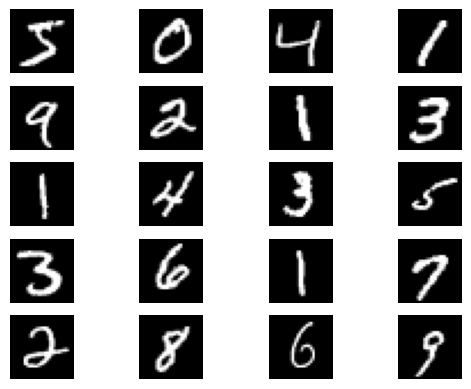

In [11]:
# Let's plot a sample
for i in range((20)):
    plt.gray()
    plt.subplot(5,4,i+1)
    plt.axis("off")
    plt.imshow(X_train[i])
#     plt.title(Y_train[i])
plt.show()

In [12]:
# Let's scale the data
X_train_scaled=X_train/255
X_test_scaled=X_test/255

In [14]:
X_train_scaled[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [16]:
size,row,col=X_train_scaled.shape

In [17]:
size

60000

In [18]:
X_train=X_train_scaled.reshape(size,row*col)

In [19]:
X_train.shape

(60000, 784)

In [20]:
X_test = X_test.reshape(-1, row*col)

In [21]:
X_test.shape

(10000, 784)

In [22]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
Y_train[0]

5

In [38]:
# Generator Model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from keras.optimizers import SGD, Adam
noise_shape=100
image_shape=row*col
def generator_model(noise_shape):
    model=Sequential()
#     hidden layers
    model.add(Dense(256,activation=LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization(momentum=0.7))
    model.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization(momentum=0.7))
    model.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization(momentum=0.7))
    
#     output layer
    model.add(Dense(image_shape,activation='tanh'))
    
#     model.summary()
    
#     input
    noise=Input(shape=(noise_shape,))
#     output
    img=model(noise)
    
    return Model(noise,img)

In [39]:
def discriminator_model(img):
    model=Sequential()
    model.add(Dense(256,activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
    
#     output layer
    model.add(Dense(1,activation='sigmoid'))
    
#     input
    img=Input(shape=image_shape)
#     output
    validity=model(img)
    
    return Model(img,validity)

In [40]:
# Let's compile the discriminator
discriminator=discriminator_model(row*col)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# building generator model
generator=generator_model(noise_shape)

In [41]:
z=Input(shape=(noise_shape,))
img=generator(z)
discriminator.trainable=False
fake_pred=discriminator(img)

In [46]:
combined_model_gen = Model(z, fake_pred)  #first is noise and 2nd is fake prediction
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [48]:
import os
batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []
#create a file in which generator will create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [57]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, noise_shape)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):  #5*5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(row, col), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [58]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  real_imgs = X_train[idx]  #MNIST dataset
  # Generate fake images
  noise = np.random.randn(batch_size, noise_shape)  #generator to generate fake imgs
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
  noise = np.random.randn(batch_size, noise_shape)
  g_loss = combined_model_gen.train_on_batch(noise, ones)  
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, noise_shape)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
  d_losses.append(d_loss)  #save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

1/1 [==============================] - 0s 29ms/step
epoch: 1/12000, d_loss: 0.66, d_acc: 0.56, g_loss: 0.68
1/1 [==============================] - 0s 24ms/step
epoch: 101/12000, d_loss: 0.28, d_acc: 0.89, g_loss: 2.00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 201/12000, d_loss: 0.71, d_acc: 0.50, g_loss: 1.38
1/1 [==============================] - 0s 12ms/step
epoch: 301/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 1.23
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 401/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 1.20
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 29ms/step
epoch: 501/12000, d_loss: 0.64, d_acc: 0.59, g_loss: 1.04
1/1 [==============================] - 0s 22ms/step
epoch: 601/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 0.89
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 701/12000, d_loss: 0.72, d_acc: 0.42, g_loss: 0.75
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 801/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.73
1/1 [==============================] - 0s 24ms/step
epoch: 901/12000, d_loss: 0.70, d_acc: 0.55, g_loss: 0.73
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 1001/12000, d_loss: 0.62, d_acc: 0.69, g_loss: 0.87
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 1101/12000, d_loss: 0.42, d_acc: 0.81, g_loss: 1.35
1/1 [==============================] - 0s 21ms/step
epoch: 1201/12000, d_loss: 0.44, d_acc: 0.80, g_loss: 2.31
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 1301/12000, d_loss: 0.39, d_acc: 0.91, g_loss: 2.92
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 1401/12000, d_loss: 0.43, d_acc: 0.95, g_loss: 1.77
1/1 [==============================] - 0s 19ms/step
epoch: 1501/12000, d_loss: 0.38, d_acc: 0.89, g_loss: 2.77
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 1601/12000, d_loss: 0.48, d_acc: 0.83, g_loss: 2.35
1/1 [==============================] - 0s 18ms/step
epoch: 1701/12000, d_loss: 0.52, d_acc: 0.84, g_loss: 1.91


1/1 [==============================] - 0s 21ms/step
epoch: 1801/12000, d_loss: 0.43, d_acc: 0.83, g_loss: 1.53
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 1901/12000, d_loss: 0.39, d_acc: 0.91, g_loss: 3.51
1/1 [==============================] - 0s 18ms/step
epoch: 2001/12000, d_loss: 0.26, d_acc: 0.94, g_loss: 1.18
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 2101/12000, d_loss: 0.61, d_acc: 0.62, g_loss: 1.82
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 2201/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 2.56
1/1 [==============================] - 0s 16ms/step
epoch: 2301/12000, d_loss: 0.41, d_acc: 0.84, g_loss: 1.36
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 2401/12000, d_loss: 0.65, d_acc: 0.61, g_loss: 1.06
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step
epoch: 2501/12000, d_loss: 0.37, d_acc: 0.84, g_loss: 1.36
1/1 [==============================] - 0s 19ms/step
epoch: 2601/12000, d_loss: 0.52, d_acc: 0.75, g_loss: 2.42
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step
epoch: 2701/12000, d_loss: 0.35, d_acc: 0.89, g_loss: 1.79
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 2801/12000, d_loss: 0.64, d_acc: 0.56, g_loss: 1.16
1/1 [==============================] - 0s 20ms/step
epoch: 2901/12000, d_loss: 0.64, d_acc: 0.56, g_loss: 1.22
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 3001/12000, d_loss: 0.49, d_acc: 0.88, g_loss: 1.54
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 3101/12000, d_loss: 0.71, d_acc: 0.47, g_loss: 1.79
1/1 [==============================] - 0s 19ms/step
epoch: 3201/12000, d_loss: 0.47, d_acc: 0.80, g_loss: 7.24
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 3301/12000, d_loss: 0.48, d_acc: 0.84, g_loss: 1.75
1/1 [==============================] - 0s 16ms/step
epoch: 3401/12000, d_loss: 0.41, d_acc: 0.88, g_loss: 1.53
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 3501/12000, d_loss: 0.56, d_acc: 0.62, g_loss: 1.08
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 3601/12000, d_loss: 0.44, d_acc: 0.78, g_loss: 2.13
1/1 [==============================] - 0s 19ms/step
epoch: 3701/12000, d_loss: 0.49, d_acc: 0.86, g_loss: 1.15
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 3801/12000, d_loss: 0.38, d_acc: 0.89, g_loss: 1.78
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 3901/12000, d_loss: 0.60, d_acc: 0.72, g_loss: 2.10
1/1 [==============================] - 0s 21ms/step
epoch: 4001/12000, d_loss: 0.44, d_acc: 0.80, g_loss: 1.95
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
epoch: 4101/12000, d_loss: 0.40, d_acc: 0.86, g_loss: 2.71
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 4201/12000, d_loss: 0.36, d_acc: 0.86, g_loss: 2.02
1/1 [==============================] - 0s 23ms/step
epoch: 4301/12000, d_loss: 0.47, d_acc: 0.81, g_loss: 1.84
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 4401/12000, d_loss: 0.50, d_acc: 0.86, g_loss: 1.91
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 4501/12000, d_loss: 0.43, d_acc: 0.86, g_loss: 2.27
1/1 [==============================] - 0s 18ms/step
epoch: 4601/12000, d_loss: 0.33, d_acc: 0.94, g_loss: 2.43
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step
epoch: 4701/12000, d_loss: 0.43, d_acc: 0.84, g_loss: 2.21
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 4801/12000, d_loss: 0.35, d_acc: 0.91, g_loss: 2.20
1/1 [==============================] - 0s 21ms/step
epoch: 4901/12000, d_loss: 0.31, d_acc: 0.97, g_loss: 1.99
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 29ms/step
epoch: 5001/12000, d_loss: 0.32, d_acc: 0.94, g_loss: 2.68
1/1 [==============================] - 0s 21ms/step
epoch: 5101/12000, d_loss: 0.31, d_acc: 0.86, g_loss: 2.47
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 5201/12000, d_loss: 0.40, d_acc: 0.86, g_loss: 2.13
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 5301/12000, d_loss: 0.31, d_acc: 0.95, g_loss: 3.83
1/1 [==============================] - 0s 16ms/step
epoch: 5401/12000, d_loss: 0.38, d_acc: 0.78, g_loss: 2.61
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 5501/12000, d_loss: 0.34, d_acc: 0.91, g_loss: 3.12
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 5601/12000, d_loss: 0.33, d_acc: 0.92, g_loss: 6.75
1/1 [==============================] - 0s 19ms/step
epoch: 5701/12000, d_loss: 0.31, d_acc: 0.88, g_loss: 1.79
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 5801/12000, d_loss: 0.25, d_acc: 0.91, g_loss: 3.68
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 5901/12000, d_loss: 0.23, d_acc: 0.91, g_loss: 5.73
1/1 [==============================] - 0s 16ms/step
epoch: 6001/12000, d_loss: 0.22, d_acc: 0.88, g_loss: 5.42
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 6101/12000, d_loss: 0.24, d_acc: 0.95, g_loss: 11.14
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 6201/12000, d_loss: 0.22, d_acc: 0.92, g_loss: 3.35
1/1 [==============================] - 0s 13ms/step
epoch: 6301/12000, d_loss: 0.24, d_acc: 0.97, g_loss: 4.07
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step
epoch: 6401/12000, d_loss: 0.23, d_acc: 0.97, g_loss: 4.85
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 6501/12000, d_loss: 0.21, d_acc: 0.94, g_loss: 2.48
1/1 [==============================] - 0s 21ms/step
epoch: 6601/12000, d_loss: 0.38, d_acc: 0.84, g_loss: 2.60
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 6701/12000, d_loss: 0.23, d_acc: 0.91, g_loss: 5.12
1/1 [==============================] - 0s 21ms/step
epoch: 6801/12000, d_loss: 0.30, d_acc: 0.84, g_loss: 4.23
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 6901/12000, d_loss: 0.20, d_acc: 0.95, g_loss: 3.70
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 7001/12000, d_loss: 0.26, d_acc: 0.91, g_loss: 4.97
1/1 [==============================] - 0s 22ms/step
epoch: 7101/12000, d_loss: 0.21, d_acc: 0.88, g_loss: 4.96
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 7201/12000, d_loss: 0.25, d_acc: 0.89, g_loss: 8.65
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 7301/12000, d_loss: 0.34, d_acc: 0.81, g_loss: 5.01
1/1 [==============================] - 0s 25ms/step
epoch: 7401/12000, d_loss: 0.23, d_acc: 0.91, g_loss: 4.69
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 7501/12000, d_loss: 0.20, d_acc: 0.94, g_loss: 6.37
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 7601/12000, d_loss: 0.20, d_acc: 0.94, g_loss: 3.55
1/1 [==============================] - 0s 23ms/step
epoch: 7701/12000, d_loss: 0.30, d_acc: 0.89, g_loss: 2.87
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 7801/12000, d_loss: 0.24, d_acc: 0.83, g_loss: 4.29
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 7901/12000, d_loss: 0.37, d_acc: 0.81, g_loss: 3.02
1/1 [==============================] - 0s 17ms/step
epoch: 8001/12000, d_loss: 0.29, d_acc: 0.86, g_loss: 3.88
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 8101/12000, d_loss: 0.14, d_acc: 0.97, g_loss: 5.74
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 8201/12000, d_loss: 0.17, d_acc: 0.94, g_loss: 5.46
1/1 [==============================] - 0s 18ms/step
epoch: 8301/12000, d_loss: 0.17, d_acc: 0.95, g_loss: 5.96
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 8401/12000, d_loss: 0.11, d_acc: 0.97, g_loss: 6.51
1/1 [==============================] - 0s 22ms/step
epoch: 8501/12000, d_loss: 0.13, d_acc: 0.94, g_loss: 4.87
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 8601/12000, d_loss: 0.26, d_acc: 0.92, g_loss: 6.45
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 8701/12000, d_loss: 0.21, d_acc: 0.92, g_loss: 6.20
1/1 [==============================] - 0s 25ms/step
epoch: 8801/12000, d_loss: 0.36, d_acc: 0.84, g_loss: 12.29
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 8901/12000, d_loss: 0.16, d_acc: 0.95, g_loss: 6.64
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 9001/12000, d_loss: 0.16, d_acc: 0.94, g_loss: 5.06
1/1 [==============================] - 0s 32ms/step
epoch: 9101/12000, d_loss: 0.20, d_acc: 0.95, g_loss: 8.67
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 9201/12000, d_loss: 0.15, d_acc: 0.95, g_loss: 16.78
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 9301/12000, d_loss: 0.19, d_acc: 0.92, g_loss: 4.31
1/1 [==============================] - 0s 23ms/step
epoch: 9401/12000, d_loss: 0.18, d_acc: 0.94, g_loss: 5.50
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 9501/12000, d_loss: 0.21, d_acc: 0.89, g_loss: 12.02
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step
epoch: 9601/12000, d_loss: 0.14, d_acc: 0.94, g_loss: 3.77
1/1 [==============================] - 0s 19ms/step
epoch: 9701/12000, d_loss: 0.24, d_acc: 0.91, g_loss: 6.80
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 9801/12000, d_loss: 0.14, d_acc: 0.94, g_loss: 4.90
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 9901/12000, d_loss: 0.15, d_acc: 0.97, g_loss: 5.90
1/1 [==============================] - 0s 18ms/step
epoch: 10001/12000, d_loss: 0.17, d_acc: 0.95, g_loss: 5.09
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 10101/12000, d_loss: 0.19, d_acc: 0.92, g_loss: 5.13
1/1 [==============================] - 0s 20ms/step
epoch: 10201/12000, d_loss: 0.16, d_acc: 0.95, g_loss: 5.22
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 10301/12000, d_loss: 0.15, d_acc: 0.94, g_loss: 3.95
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 10401/12000, d_loss: 0.17, d_acc: 0.95, g_loss: 4.72
1/1 [==============================] - 0s 22ms/step
epoch: 10501/12000, d_loss: 0.13, d_acc: 0.98, g_loss: 10.81
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 10601/12000, d_loss: 0.17, d_acc: 0.94, g_loss: 5.89
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 10701/12000, d_loss: 0.24, d_acc: 0.89, g_loss: 6.13
1/1 [==============================] - 0s 20ms/step
epoch: 10801/12000, d_loss: 0.20, d_acc: 0.89, g_loss: 4.47
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 10901/12000, d_loss: 0.13, d_acc: 0.94, g_loss: 4.78
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step
epoch: 11001/12000, d_loss: 0.32, d_acc: 0.92, g_loss: 7.65
1/1 [==============================] - 0s 19ms/step
epoch: 11101/12000, d_loss: 0.17, d_acc: 0.94, g_loss: 4.48
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step
epoch: 11201/12000, d_loss: 0.08, d_acc: 0.98, g_loss: 4.55
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
epoch: 11301/12000, d_loss: 0.17, d_acc: 0.94, g_loss: 6.61
1/1 [==============================] - 0s 25ms/step
epoch: 11401/12000, d_loss: 0.21, d_acc: 0.92, g_loss: 7.93
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 11501/12000, d_loss: 0.16, d_acc: 0.92, g_loss: 4.66
1/1 [==============================] - 0s 19ms/step
epoch: 11601/12000, d_loss: 0.21, d_acc: 0.92, g_loss: 5.36


1/1 [==============================] - 0s 21ms/step
epoch: 11701/12000, d_loss: 0.09, d_acc: 0.98, g_loss: 6.26
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step
epoch: 11801/12000, d_loss: 0.21, d_acc: 0.94, g_loss: 4.72
1/1 [==============================] - 0s 19ms/step
epoch: 11901/12000, d_loss: 0.20, d_acc: 0.91, g_loss: 7.07
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step
